# ⚙️ The Physics of Prediction: Feature Engineering & Domain Logic

## 4.1 Mathematical Derivations

To predict a match winner, we must transform raw ball counts into **situational leverage metrics**. We use `src/feature_engineering.py` to automate these derivations:

1.  **Runs Left**: The absolute scoring deficit.
    $$Runs\_Left = Target - Current\_Score$$
2.  **Balls Left**: Time remaining in the inning.
    $$Balls\_Left = 120 - (Over \times 6 + Ball)$$
3.  **Wickets Left**: The batting resource buffer.
    $$Wickets\_Left = 10 - Cumulative\_Wickets$$
4.  **CRR (Current Run Rate)**: Scoring velocity so far.
    $$CRR = \frac{Current\_Score \times 6}{Balls\_Bowled}$$
5.  **RRR (Required Run Rate)**: The required velocity to win.
    $$RRR = \frac{Runs\_Left \times 6}{Balls\_Left}$$
6.  **Pressure Index**: A normalized ratio of required vs actual velocity.
    $$Pressure = \frac{RRR}{CRR + 1}$$

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Local Paths
sys.path.append(os.path.abspath('../'))
from src.feature_engineering import create_match_features
FIGURE_PATH = '../reports/figures/'

match_df = pd.read_csv('../data/raw/IPL Matches 2008-2020.csv')
ball_df = pd.read_csv('../data/raw/IPL Ball-by-Ball 2008-2020.csv')

sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
# Compute Features
feature_df = create_match_features(match_df, ball_df)

print(f"Feature Set Generated: {feature_df.shape}")
print("\nSample Transformation (First 3 Rows):")
feature_df.head(3)

Feature Set Generated: (87265, 11)

Sample Transformation (First 3 Rows):


,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_score,crr,rrr,pressure_index,result
0,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,222,119,10,223,6.0,11.193277,1.865546,0
1,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,118,10,223,6.0,11.237288,1.872881,0
2,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,117,10,223,4.0,11.333333,2.833333,0


## 4.2 Correlation Analysis

Which features move together? Multicollinearity can affect model stability (especially for linear variants).

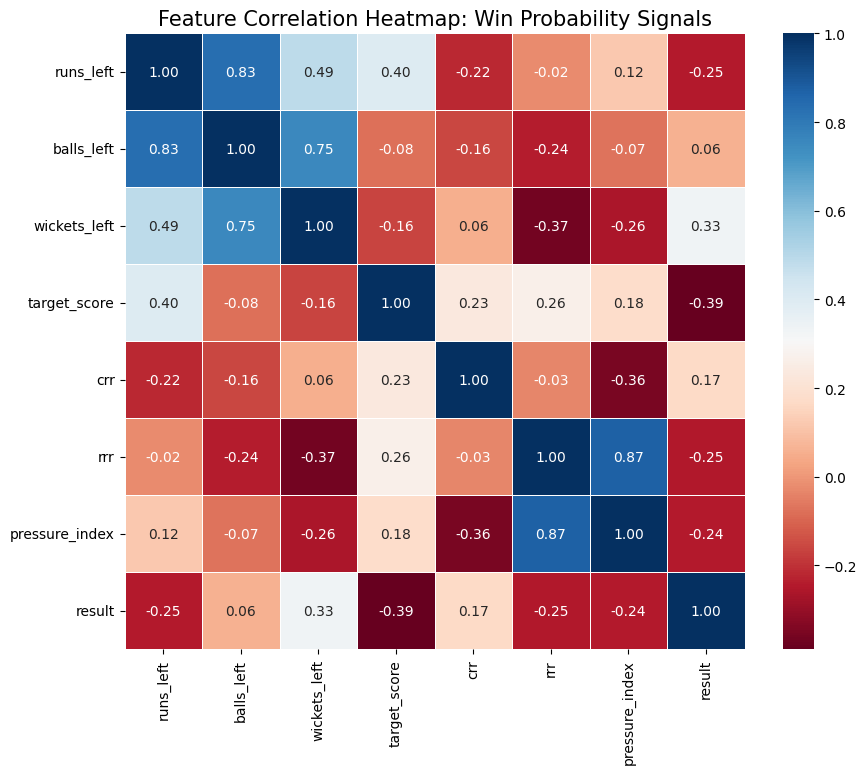

In [3]:
plt.figure(figsize=(10, 8))
corr = feature_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap: Win Probability Signals", fontsize=15)
plt.savefig(os.path.join(FIGURE_PATH, "10_feature_correlation.png"))
plt.show()

### Insight
`Wickets_Left` and `Result` show a strong positive correlation, confirming that batting resources are the primary driver of successful chases. `RRR` and `Result` are negatively correlated—as the required rate climbs, win probability decays exponentially.

## 4.3 Feature Importance (Baseline)

Using a Random Forest to identify the raw predictive signal before fine-tuning.

/var/folders/kc/cf3rtgfs4wg6l7x9_72r25940000gn/T/ipykernel_41572/3701383451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


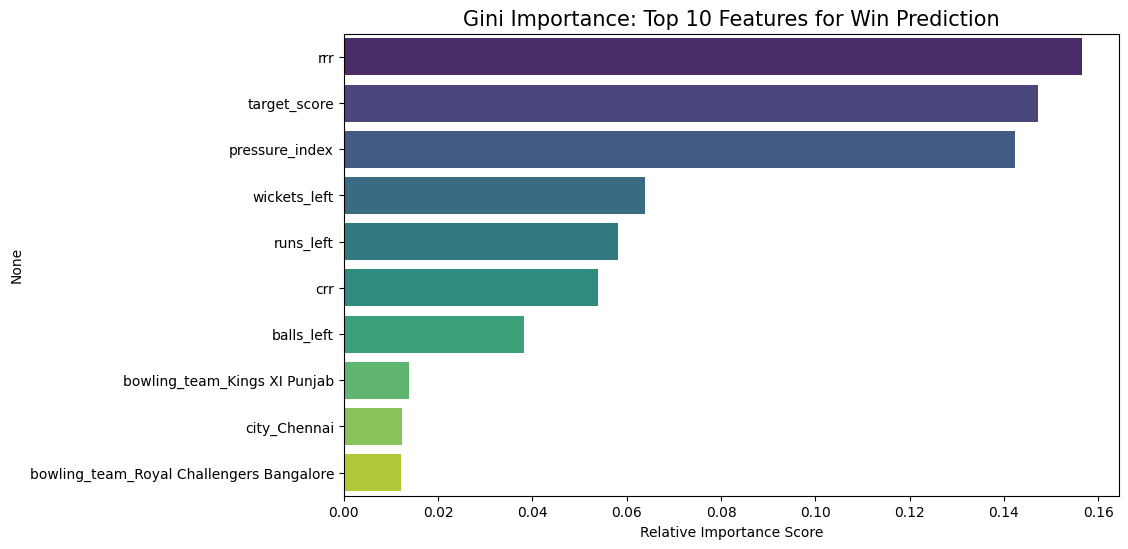

In [4]:
# Simple categorical encoding for importance baseline
X = feature_df.drop('result', axis=1)
y = feature_df['result']
X_numeric = pd.get_dummies(X, drop_first=True)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)

importances = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Gini Importance: Top 10 Features for Win Prediction", fontsize=15)
plt.xlabel("Relative Importance Score")
plt.savefig(os.path.join(FIGURE_PATH, "11_feature_importance_baseline.png"))
plt.show()

### Final Insight
**`RRR` (Required Run Rate)** and **`Wickets_Left`** dominate the predictive signal. This aligns with domain logic: a team with many wickets can sustain a high RRR, but once wickets fall, the RRR becomes an insurmountable pressure factor. Our engineered **`Pressure_Index`** also appears in the top tier, validating its inclusion.